In [47]:
import spikeinterface.full as si
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from probeinterface.plotting import plot_probe

In [48]:
path = r"Z:\projects\sequence_squad\revision_data\lars_recordings\ephys\dual_strd_hpc\seq008_2024-11-11_14-46-19\\"
# extract the stream names (each np processor)
stream_names, stream_ids = si.get_neo_streams('openephysbinary', path)
print(stream_names)

['Record Node 103#NI-DAQmx-102.PXIe-6341', 'Record Node 103#Neuropix-PXI-100.ProbeA', 'Record Node 103#Neuropix-PXI-100.ProbeB']


(<matplotlib.collections.PolyCollection at 0x25a3e7dd610>,
 <matplotlib.collections.PolyCollection at 0x2094c88f4d0>)

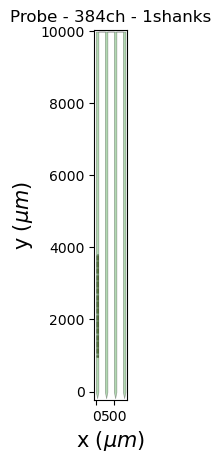

In [49]:
# load in probe A 
raw_rec = si.read_openephys(path,stream_name = stream_names[1],load_sync_channel=False)
raw_rec.get_probe().to_dataframe()
# fig, ax = plt.subplots(figsize=(15, 10))
# si.plot_probe_map(raw_rec, ax=ax, with_channel_ids=True)
# # ax.set_ylim(1000, 1300)

probe = raw_rec.get_probe()
plot_probe(probe)

In [50]:
# # load in probe A 
# raw_rec = si.read_openephys(path,stream_name = stream_names[2],load_sync_channel=False)
# raw_rec.get_probe().to_dataframe()
# # fig, ax = plt.subplots(figsize=(15, 10))
# # si.plot_probe_map(raw_rec, ax=ax, with_channel_ids=True)
# # # ax.set_ylim(1000, 1300)

# probe = raw_rec.get_probe()
# plot_probe(probe)

Preprocess the recording¶
Let’s do something similar to the IBL destriping chain (See :ref:ibl_destripe) to preprocess the data but:

instead of interpolating bad channels, we remove then.

instead of highpass_spatial_filter() we use common_reference()

In [51]:
rec1 = si.highpass_filter(raw_rec, freq_min=400.)
bad_channel_ids, channel_labels = si.detect_bad_channels(rec1)
rec2 = rec1.remove_channels(bad_channel_ids)
print('bad_channel_ids', bad_channel_ids)

rec3 = si.phase_shift(rec2)
rec4 = si.common_reference(rec3, operator="median", reference="global")
rec = rec4
rec

bad_channel_ids []


CommonReferenceRecording: 384 channels - 30.0kHz - 1 segments - 440,454,525 samples 
                          14,681.82s (4.08 hours) - int16 dtype - 315.04 GiB